# 1. Setup workspace and Import packages

In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/Ocean mixing new


# 2. Data

In [3]:
# Load GOTM training data produced by Sane et al. 2023
# Plot the assumed univeral shape function vs. GOTM results to illustrate the qualitative differences

store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/raw_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

In [4]:
# Apply the constraints defined above
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]
# Filter the data to only those that obey the constraints
# ind7 is the final filter to indentify the data that will be input to N1 training
ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6) 

In [5]:
# there are 16 levels (1 at bottom, 16 at top)
mm1=0; mm2=16  #0; 16
# apply ind7 to keep only the profiles that meet the filtering criteria
# Training uses only 4 inputs: Coriolis parameter (l0), buoyancy flux (b00), surface friction velocity (ustar0) and boundary layer depth (h0)
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)  
# Note: ff.preprocess_train_data is a custom function defined in lib/func_file.py that normalizes, log-transforms and shuffles the dataset


started


In [6]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [7]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

In [8]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)  # First layer: Input to hidden
        self.linear2 = nn.Linear(Hid, Hid)       # Second layer: Hidden to hidden
        self.linear3 = nn.Linear(Hid, Out_nodes) # Third layer: Hidden to output
        self.dropout = nn.Dropout(0.25)          # Dropout for regularization

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)            # ReLU activation for layer 1
        h1 = self.dropout(h1)          # Apply dropout
        
        h2 = self.linear2(h1)
        h3 = torch.relu(h2)            # ReLU activation for layer 2
        h3 = self.dropout(h3)          # Apply dropout

        y_pred = self.linear3(h3)      # Final output layer
        return y_pred


In [9]:
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr)  # Adam optimizer
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data
            
            valid_pred = model(valid_x)  # Forward pass for validation data
            
            # Loss used for gradient calculation
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            
            loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()  
            loss_array[k, 2] = loss_valid.item()  

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(), 
                valid_loss=loss_valid.item(), 
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()  
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Free memory by deleting intermediate variables
            del loss, y_pred
            
    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, loss_array[:k, :]


In [10]:
# Loss weighting option here, all weights = 1.0 in default run 
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [11]:
# Train N1 for the first time!
epochs, k_points, lr=3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

### in this version, there is no weighting in the loss function. This will be added in section 6. 

Training Progress:  26%|██▌       | 767/3000 [00:25<01:14, 29.80epoch/s, patience_count=19, train_loss=0.0387, valid_loss=0.0557]



Early stopping at epoch 767. Validation loss has not improved for 20 epochs.


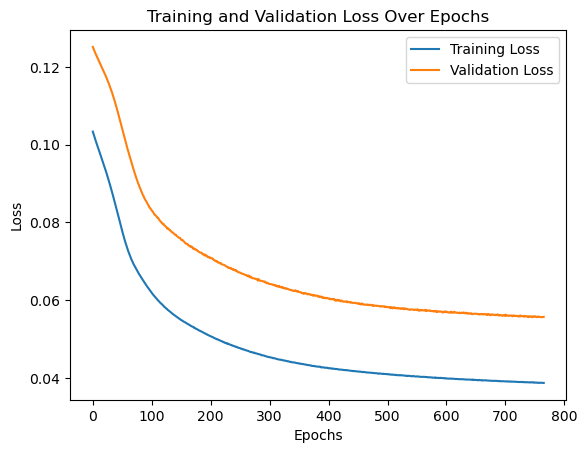

In [12]:
plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss")
plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss")

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


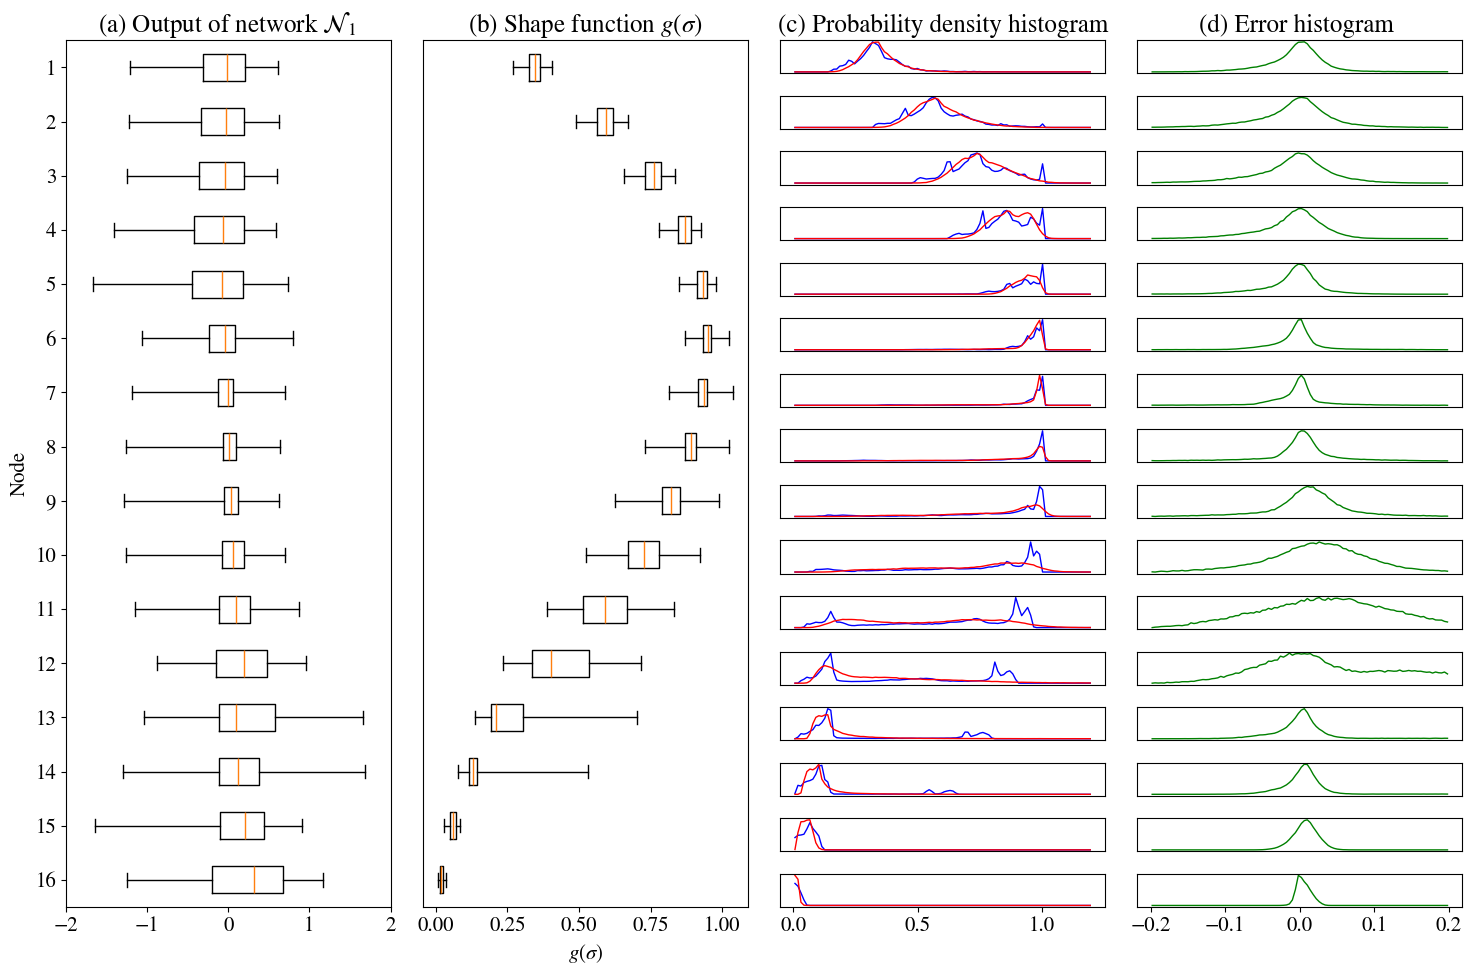

In [13]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

In [14]:
x_original = x.clone()
y_original = y.clone()
valid_x_original = valid_x.clone()
valid_y_original = valid_y.clone()

Training RF per-node models: 100%|██████████| 16/16 [12:53<00:00, 48.34s/it]


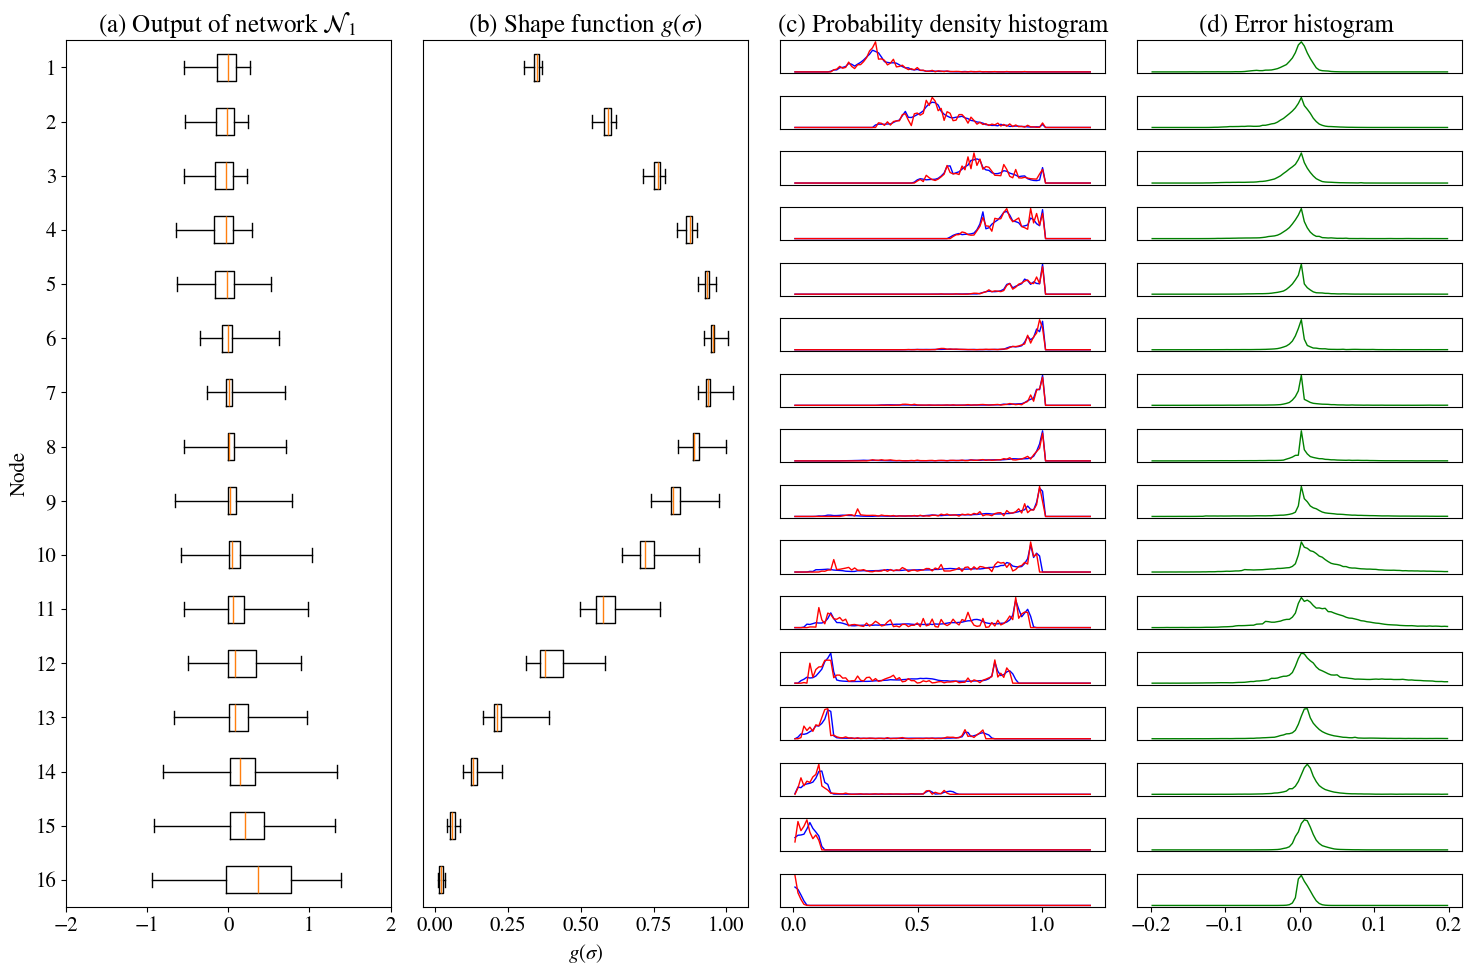

In [18]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import numpy as np
import torch

# the input data is in numpy format
x_np = x_original.detach().cpu().numpy()
y_np = y_original.detach().cpu().numpy()
valid_x_np = valid_x_original.detach().cpu().numpy()
valid_y_np = valid_y_original.detach().cpu().numpy()


# Train 16 independent RF models (corresponding to g(σ₁) ~ g(σ₁₆)) and display progress
rf_models = []
with tqdm(total=16, desc="Training RF per-node models") as pbar:
    for i in range(16):
        rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=12,
            min_samples_split=3,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(x_np, y_np[:, i])
        rf_models.append(rf)
        pbar.update(1)

# Define a wrapper class to be compatible with performance_sigma_point()
class RFPerNodeWrapper(torch.nn.Module):
    def __init__(self, rf_models, k_mean, k_std):
        super().__init__()
        self.models = rf_models
        self.k_mean = torch.tensor(k_mean).float()
        self.k_std = torch.tensor(k_std).float()

    def forward(self, x):
        x_np = x.detach().cpu().numpy()
        # 每个模型单独预测，然后拼接
        preds = [model.predict(x_np) for model in self.models]
        y_pred = np.stack(preds, axis=1)  # shape: [N, 16]
        return torch.tensor(y_pred).float()

# Package into a “model” supported by the visualization function
model_rf_pernode = RFPerNodeWrapper(rf_models, k_mean, k_std).to(device)
performance_sigma_point(model_rf_pernode, x_original, valid_x, y_original, valid_y, k_mean, k_std)